In [1]:
import pandas as pd
import numpy as np

# my own modules for building risk models, 
# see description here https://github.com/messiah1349/woe_transformer/tree/main
from woe_transformer.utils.model_functions import (
    ModelPipeline,
    splitting,
    LogReg
)
from woe_transformer.utils.woe_functions import WoeTransformer

pd.set_option('display.max_columns', None)


# classification

## read train data

In [2]:
df = pd.read_excel('data/DS_test_data.xlsx', sheet_name='Train', index_col='id')
df[:3]

,age,age_rounded,sex,live_place_change,foreign_pass,marriage,children,dependents,education,languages,vehicle,occupational_area,work_by_edu,gov_work,position,family_income,family_member_income,personal_income,credit_sum,branch,city,requested_sum,owner_fact,spouse_income,closed_credits,first_credit,Default60
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,26.936986,27,1,0,0,2,0,0,2,4,3,35,2,3,5,20000,20000.0,20000,60000.0,27,10,60000,5,0,0,0,0
3,31.742466,32,2,0,0,1,2,2,2,4,3,11,3,3,6,22000,5500.0,10000,50000.0,29,12,50000,4,12000,0,1,0
4,23.172603,23,1,0,0,1,1,1,2,3,3,32,1,1,3,15000,5000.0,15000,30000.0,39,1,30000,3,0,1,0,1


In [3]:
df.columns

Index(['age', 'age_rounded', 'sex', 'live_place_change', 'foreign_pass',
       'marriage', 'children', 'dependents', 'education', 'languages',
       'vehicle', 'occupational_area', 'work_by_edu', 'gov_work', 'position',
       'family_income', 'family_member_income', 'personal_income',
       'credit_sum', 'branch', 'city', 'requested_sum', 'owner_fact',
       'spouse_income', 'closed_credits', 'first_credit', 'Default60'],
      dtype='object')

In [4]:
categorical_columns = ['sex', 'work_by_edu', 'gov_work', 'position', 'branch', 'city', 'owner_fact']
target = 'Default60'
numeric_columns = list(set(df.columns) - set(categorical_columns) - set([target]))
feature_names = numeric_columns + categorical_columns

df[categorical_columns] = df[categorical_columns].astype(str)

## build models

In [5]:
lgb_params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "max_bin": 4,
        "max_depth" : 2,
        "num_leaves": 3,
        "min_data_in_leaf" : 3,
        "learning_rate": 0.2,
        "regularization": 'lambda_l2',
        "bagging_fraction": 0.7,
        "feature_fraction": 0.5,
        "bagging_seed": 2018,
        "verbosity": -1
    }

feature_names, X_train, y_train, X_test, y_test = splitting(
    data = df[feature_names], 
    default_flg=df[[target]]
)

model_pipeline = ModelPipeline(
    feature_names=feature_names,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    lgb_params=lgb_params,
    fi_border=500
)

    inititally we will build lightgbm with all features
    then will choose feature top and build lightgbm only for this feature set
    finally will build logistic regression after feature woe transformation

building Lightgbm with all features:


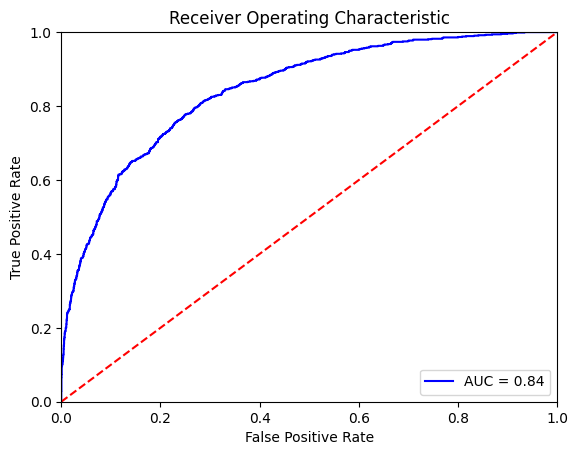

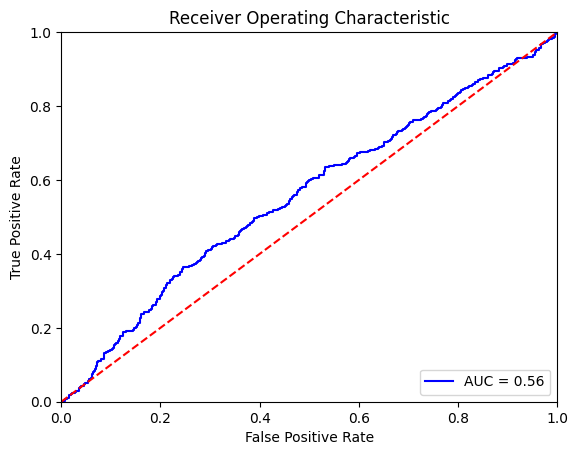

top features:
children
spouse_income
marriage
dependents
owner_fact
city
age_rounded
position
branch
family_income
live_place_change
family_member_income
credit_sum
personal_income
gov_work
work_by_edu
occupational_area
requested_sum
age
languages


building Lightgbm with only top features:


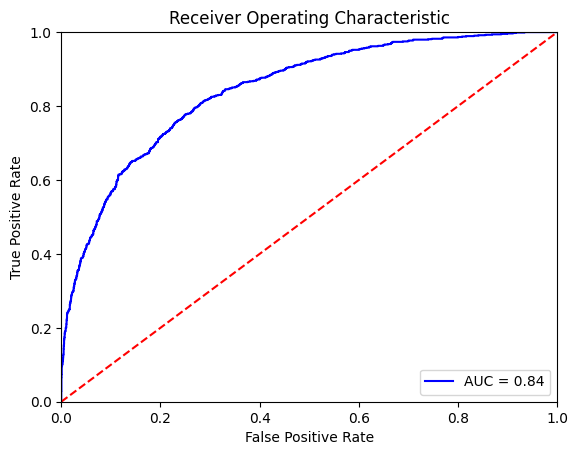

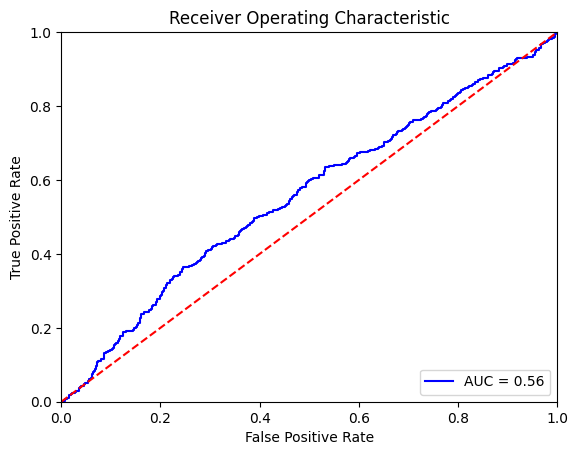

build woe transform:
build logistic regression with woe columns


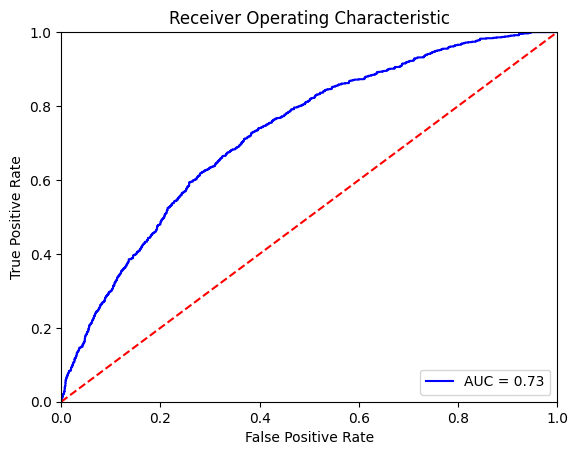

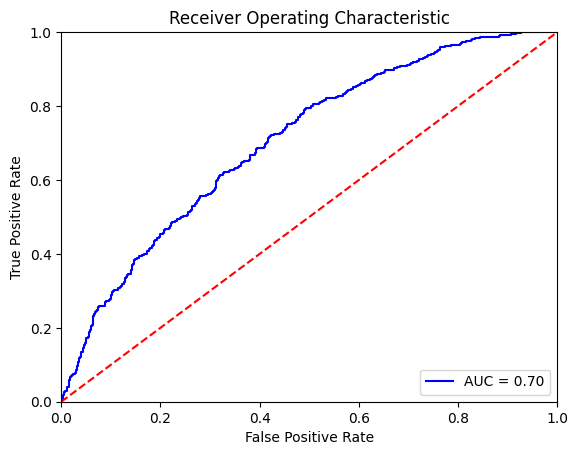

In [6]:
model_pipeline.build()

    Lightgbm unstable, mb parameters tuning can help, but train sample is too small for that

    Logistic regression works good auc = 70 for test sample, so will take it

In [7]:
lr_model = model_pipeline.lr_woe
woe_table = model_pipeline.woe.woe_table

### calculate scores and coefficients of log regression

In [8]:
woe_filtered, fin_score = lr_model.get_woe_output(woe_table, df, factor_koeff=40, offset_start=500)
fin_score[:3]

,age_point,age_rounded_point,branch_point,children_point,city_point,credit_sum_point,dependents_point,family_income_point,family_member_income_point,gov_work_point,languages_point,live_place_change_point,marriage_point,occupational_area_point,owner_fact_point,personal_income_point,position_point,requested_sum_point,spouse_income_point,work_by_edu_point,intercept,score_value
id,,,,,,,,,,,,,,,,,,,,,,
1,-17.382687,7.340819,20.145782,1.131666,0.191479,-7.426786,3.134761,0.10926,3.80520,10.118412,-0.093727,-1.073858,-1.059819,-1.702604,0.890338,-5.211243,-0.421287,8.496276,-4.295399,-1.513806,353.980549,369.163327
3,-17.382687,3.464224,19.221250,-2.138624,1.087938,-7.426786,-5.632103,0.10926,-1.31006,10.118412,-0.093727,-1.073858,-1.059819,-1.702604,1.943301,1.893753,1.202532,2.288098,2.050068,1.668694,353.980549,361.207813
4,-17.382687,7.340819,12.953964,1.131666,1.877540,-7.426786,-2.420495,0.10926,-1.31006,-4.489249,-0.093727,-1.073858,-1.059819,-1.702604,-2.077439,1.893753,-0.324879,1.968594,-4.295399,-1.670549,353.980549,335.928595


## chosing threshold

In [9]:
lr_model.calc_score_table(fin_score['score_value'])

In [10]:
score_table = lr_model.calc_score_bucket_test(num_buck=20)
score_table

,bad_rate_mean,bucket_size,bad_counts,min_pr,max_pr,low_confidence_border,upp_confidence_border
bucket,,,,,,,
0,0.000000,91,0.0,475.454478,840.801167,0.000000,0.000000
1,0.055556,90,5.0,441.096855,474.140982,0.008232,0.102879
2,0.044444,90,4.0,421.643051,440.930806,0.001869,0.087020
3,0.100000,90,9.0,409.261201,421.582493,0.038020,0.161980
4,0.144444,90,13.0,399.464624,409.109076,0.071817,0.217072
5,0.100000,90,9.0,389.541284,399.102976,0.038020,0.161980
6,0.142857,91,13.0,381.792861,389.429639,0.070961,0.214753
7,0.133333,90,12.0,375.074966,381.741259,0.063103,0.203563
8,0.144444,90,13.0,367.854539,374.922519,0.071817,0.217072


<Axes: xlabel='min_pr'>

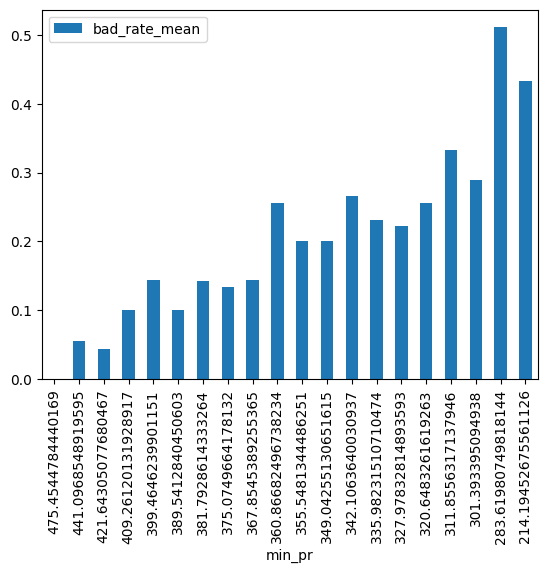

In [11]:
score_table[['bad_rate_mean', 'min_pr']].set_index('min_pr').plot(kind='bar')

In [12]:

score_threshold = 320.2
approved = score_table[score_table['min_pr'] > score_threshold]
expected_default_rate = approved['bad_counts'].sum() / approved['bucket_size'].sum()
print(f"{expected_default_rate=:.2f}")

expected_default_rate=0.16


    chosing of threshold depends on many factors. Here based only on score table we can choose score border = 320
    it border contains 4 buckets from 20. Every bucket - 5 percent of volume. So we will decline 20% of all clients.
    expected risk default rate for that threshold - 15%
    but of couse we need to do extra analysis for rejected loans

## read and score test data

In [13]:
df_test = pd.read_excel('data/DS_test_data.xlsx', sheet_name='Test', index_col='id')
df_test[categorical_columns] = df_test[categorical_columns].astype(str)

In [14]:
woe_filtered_test, fin_score_test = lr_model.get_woe_output(woe_table, df_test, factor_koeff=40, offset_start=500)

result = pd.DataFrame()
result['Score'] = fin_score_test['score_value']
result['Default60 Predicted'] = np.where(result['Score'] < score_threshold, 1, 0)
result[:10]

,Score,Default60 Predicted
id,,
6047,371.851696,0
6048,374.479227,0
6049,344.795738,0
6050,361.149421,0
6051,350.812996,0
6052,381.052253,0
6053,333.895261,0
6054,417.744058,0
6055,341.370337,0


In [15]:
result.to_excel('data/classification_task_output.xlsx')

# segmentation

In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import minmax_scale
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sne

## prepare data

In [17]:
def column_to_dummy(column: pd.Series, top_value_counts: int=10) -> pd.DataFrame:
    # we will keep only 10 most common values of categorical column
    top_values = column.value_counts()[:top_value_counts].index.tolist()
    pre_dummy_column = np.where(column.isin(top_values), column, 'other')
    pre_dummy_column = pd.Series(pre_dummy_column, index=column.index)
    return pd.get_dummies(pre_dummy_column, prefix=column.name)

dummy_dfs = [column_to_dummy(df[column]) for column in categorical_columns]
pre_cluster_df = pd.concat([df[numeric_columns]] + dummy_dfs, axis=1)
pre_cluster_df[:3]

,live_place_change,credit_sum,occupational_area,foreign_pass,education,vehicle,marriage,family_member_income,age,age_rounded,dependents,family_income,children,requested_sum,spouse_income,first_credit,languages,personal_income,closed_credits,sex_1,sex_2,work_by_edu_1,work_by_edu_2,work_by_edu_3,gov_work_1,gov_work_2,gov_work_3,position_1,position_3,position_4,position_5,position_6,branch_143,branch_153,branch_182,branch_194,branch_226,branch_227,branch_229,branch_27,branch_39,branch_79,branch_other,city_1,city_10,city_12,city_15,city_19,city_20,city_22,city_27,city_31,city_9,city_other,owner_fact_0,owner_fact_1,owner_fact_2,owner_fact_3,owner_fact_4,owner_fact_5,owner_fact_6
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,60000.0,35,0,2,3,2,20000.0,26.936986,27,0,20000,0,60000,0,0,4,20000,0,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,0,50000.0,11,0,2,3,1,5500.0,31.742466,32,2,22000,2,50000,12000,1,4,10000,0,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,0,30000.0,32,0,2,3,1,5000.0,23.172603,23,1,15000,1,30000,0,0,3,15000,1,True,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [18]:
X_sc = minmax_scale(pre_cluster_df)

## clustering

In [19]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans_pr = kmeans.fit_predict(X_sc)
cluster_series = pd.Series(kmeans_pr, index=df.index, name='cluster')
cluster_series[:3]

id
1    3
3    1
4    2
Name: cluster, dtype: int32

## visualisation

In [20]:
tsne = TSNE(n_components=2, random_state=0)
components = tsne.fit_transform(X=X_sc)
component_df = pd.DataFrame(components, columns=['c1', 'c2'], index=df.index)
component_df[:3]

,c1,c2
id,,
1,-18.011101,17.461803
3,-57.368370,29.371162
4,58.645691,16.009766


In [21]:
df_cl_res = pre_cluster_df.join(component_df).join(cluster_series)
df_cl_res[:3]

,live_place_change,credit_sum,occupational_area,foreign_pass,education,vehicle,marriage,family_member_income,age,age_rounded,dependents,family_income,children,requested_sum,spouse_income,first_credit,languages,personal_income,closed_credits,sex_1,sex_2,work_by_edu_1,work_by_edu_2,work_by_edu_3,gov_work_1,gov_work_2,gov_work_3,position_1,position_3,position_4,position_5,position_6,branch_143,branch_153,branch_182,branch_194,branch_226,branch_227,branch_229,branch_27,branch_39,branch_79,branch_other,city_1,city_10,city_12,city_15,city_19,city_20,city_22,city_27,city_31,city_9,city_other,owner_fact_0,owner_fact_1,owner_fact_2,owner_fact_3,owner_fact_4,owner_fact_5,owner_fact_6,c1,c2,cluster
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,60000.0,35,0,2,3,2,20000.0,26.936986,27,0,20000,0,60000,0,0,4,20000,0,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-18.011101,17.461803,3
3,0,50000.0,11,0,2,3,1,5500.0,31.742466,32,2,22000,2,50000,12000,1,4,10000,0,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,-57.368370,29.371162,1
4,0,30000.0,32,0,2,3,1,5000.0,23.172603,23,1,15000,1,30000,0,0,3,15000,1,True,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,58.645691,16.009766,2


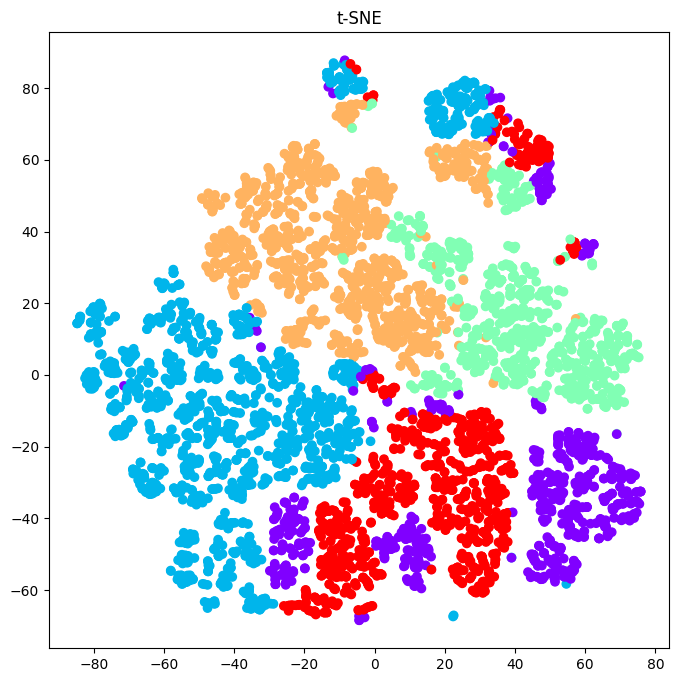

In [22]:
fig = plt.figure(figsize=(8, 8))

plt.scatter(df_cl_res['c1'], df_cl_res['c2'], c=df_cl_res['cluster'], cmap=plt.cm.rainbow)
plt.title("t-SNE")
plt.axis("tight")

plt.show()

    looks good

## data description

In [23]:
cluster_averages = df_cl_res.groupby('cluster')[pre_cluster_df.columns.tolist()].mean()
total_averages = pre_cluster_df.mean(axis=0)
total_averages = pd.Series(total_averages, name='total_average')
averages = cluster_averages.T.join(total_averages)
averages[:3]

,0,1,2,3,4,total_average
live_place_change,0.193350,0.061514,0.184783,0.115064,0.155450,0.126456
credit_sum,33914.993842,36651.857308,34868.206522,39065.064345,35418.299242,36322.930666
occupational_area,24.863300,20.966877,25.032609,24.236942,24.104265,23.385191


In [24]:
for i in range(n_clusters):
    averages[f"cl_{i}_div"] = averages[i] / averages['total_average']

<Axes: >

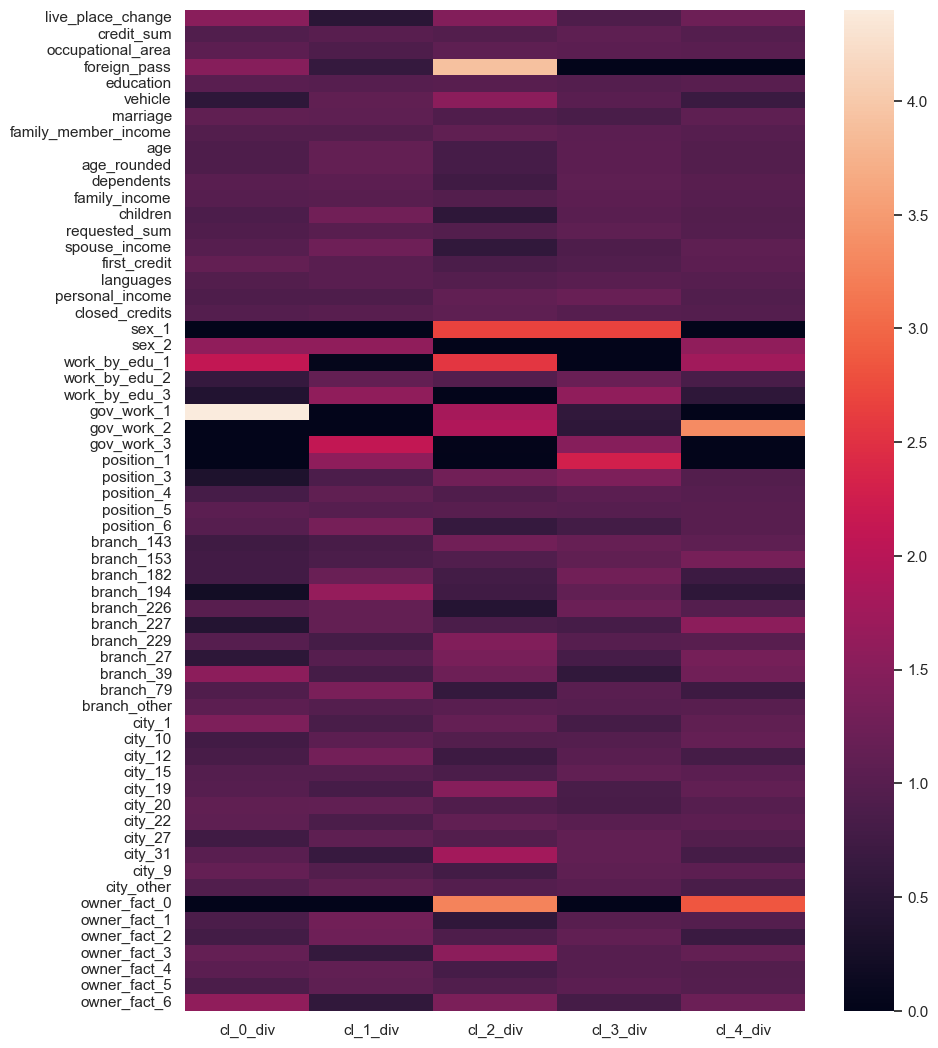

In [25]:
sne.set(rc={'figure.figsize':(10,13)})
sne.heatmap(averages.iloc[:, -n_clusters:])

    than darker than values in cluster less than average, and reverse
    so for example - first cluster mostly contains clients with owner fact = 0, work by edu = 1, sex = 1 and with foreign class

    we can try different clusterisation algorithm with different num of clusters and use different ways for data description

# bonus

## visualisation of features for classification task

    blue column - distribution of features
    red line - risk default

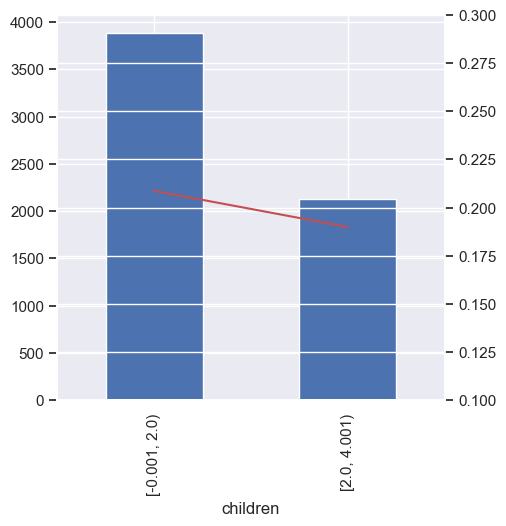

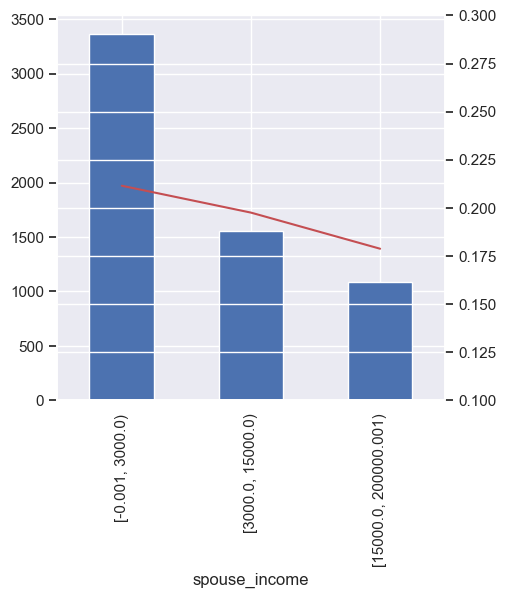

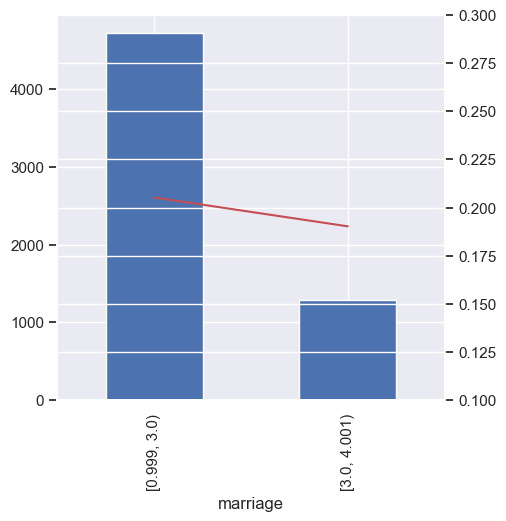

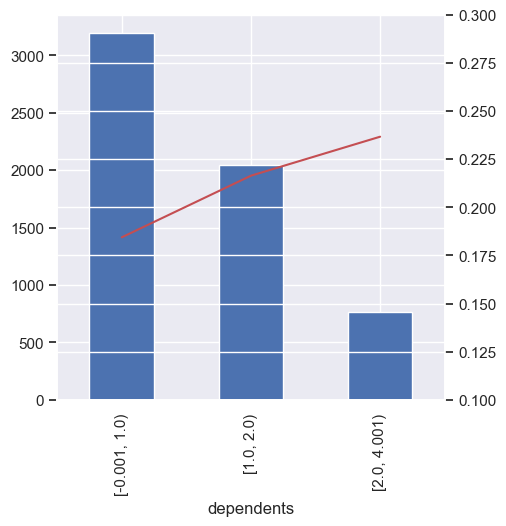

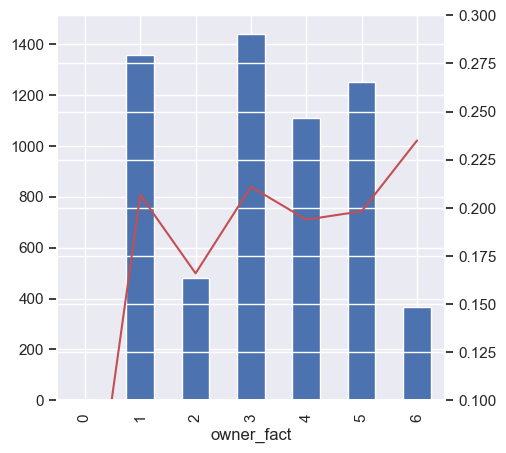

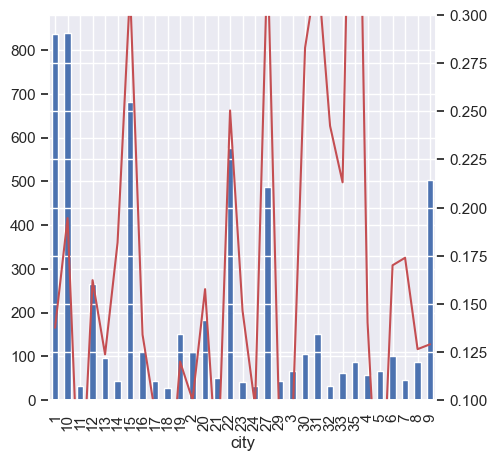

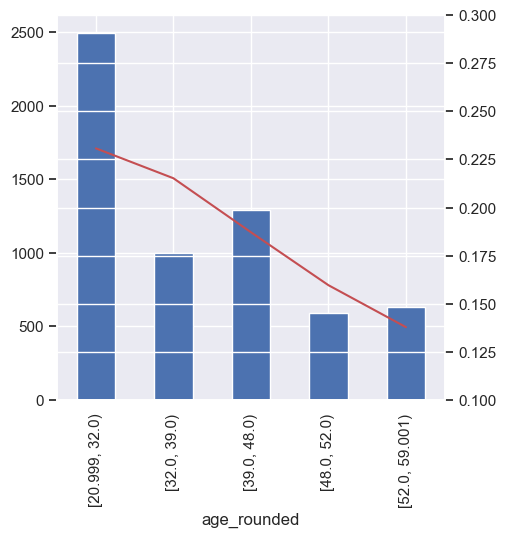

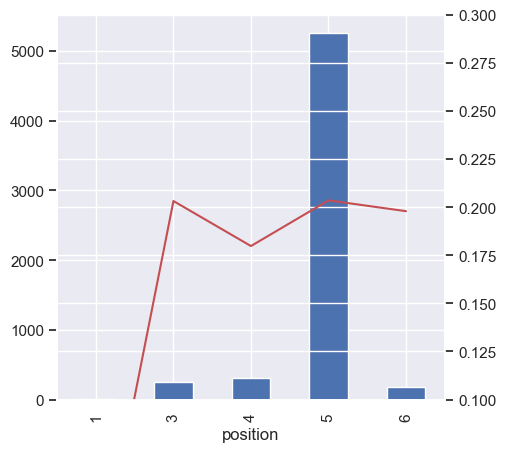

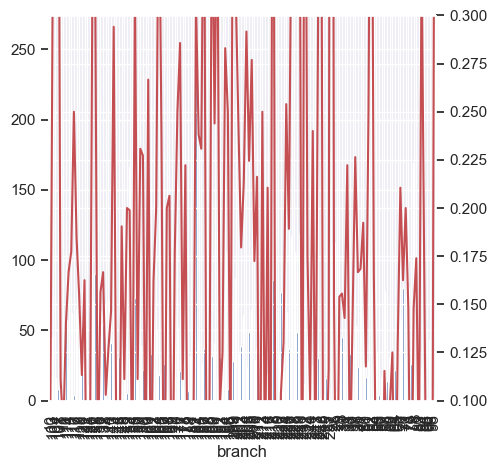

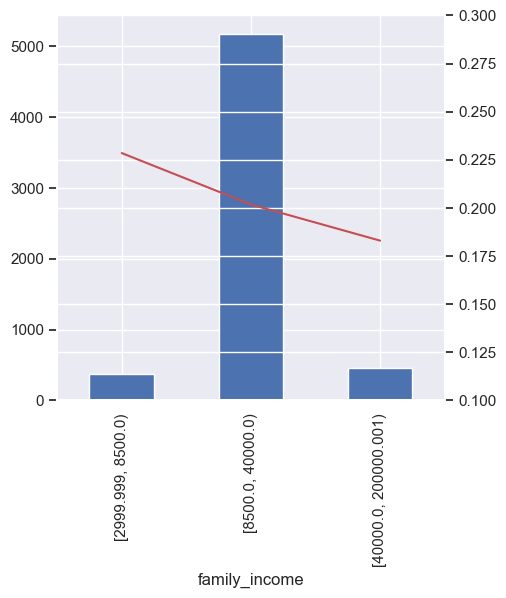

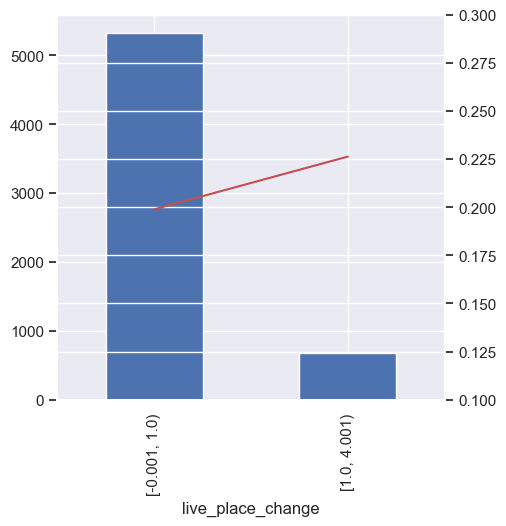

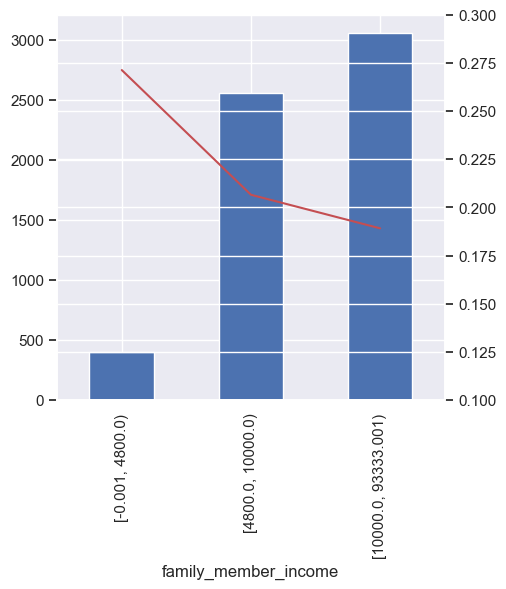

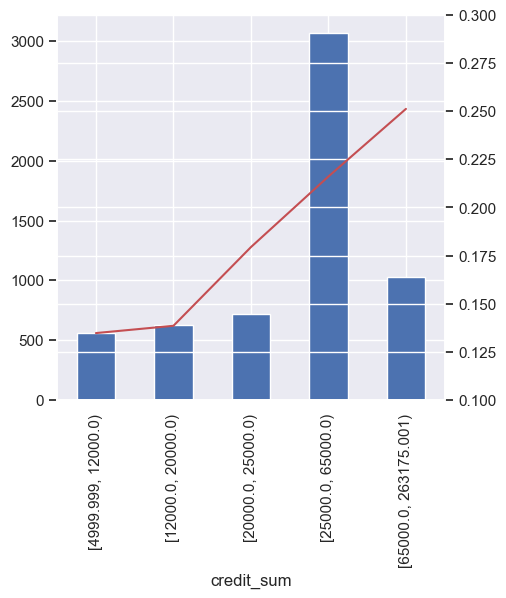

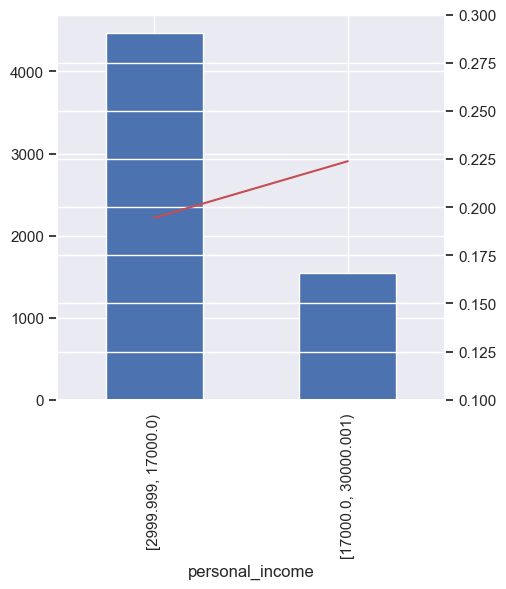

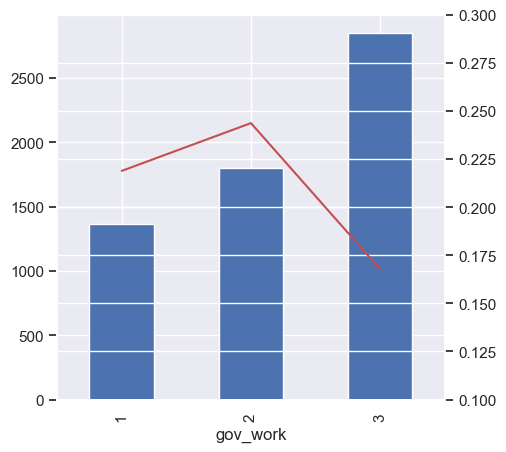

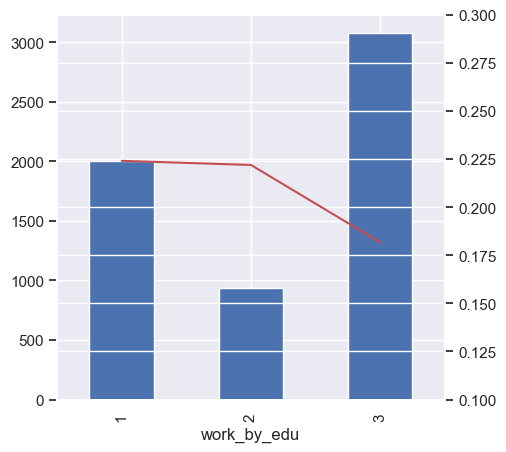

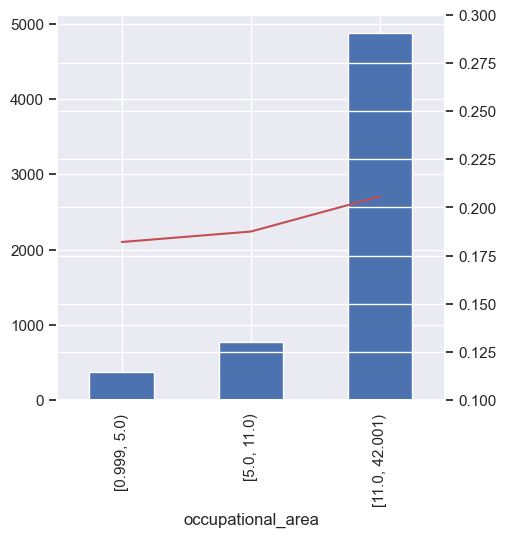

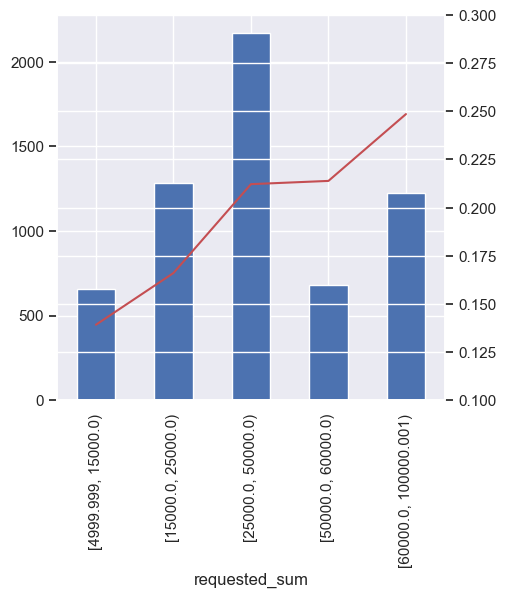

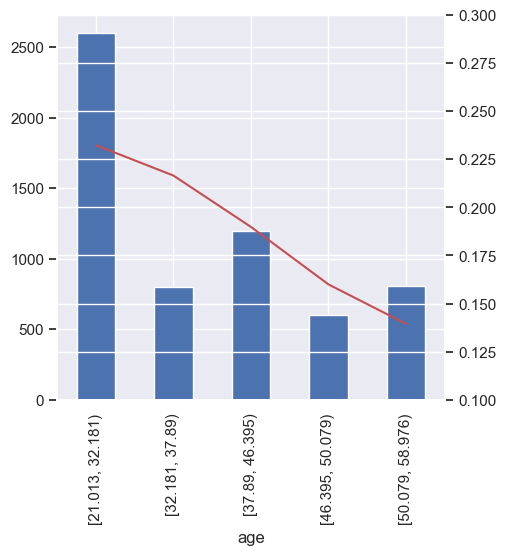

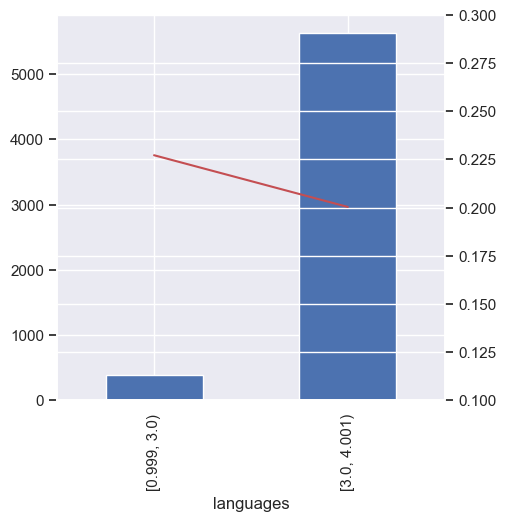

In [29]:
sne.set(rc={'figure.figsize':(5,5)})
model_pipeline.woe.draw_buckets(ylim=(0.1, 0.3))